In [1]:
import cv2
from PIL import Image
import pytesseract
pytesseract.pytesseract.tesseract_cmd = '/opt/local/bin/tesseract'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import os
import urllib.request
from pathlib import Path

from statistics import mean
from tqdm.notebook import tqdm

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.utils import shuffle

import time

from flask import Flask, request 
import random
import base64

# Data preprocessing 

## Data upload
Получим изображения для дальнейшей работы c сайта http://services.fms.gov.ru

In [2]:
#url = "http://services.fms.gov.ru/services/captcha.jpg"  
for i in range (1, 101):
    img_name = './imgs/' + str(i) + ".jpg"
    #urllib.request.urlretrieve(url, img_name)

## Data labeling
Разметим набор данных для последующего обучения и тестирования нейронной сети

In [3]:
labels = [[6,3,5,1,6,1], [3,7,8,9,7,4], [9,7,1,3,3,4], [3,3,6,2,8,7], [3,1,5,5,4,7], [8,1,8,1,4,5], [7,2,2,7,3,4],
        [7,1,3,7,9,8], [2,4,4,2,5,2], [6,1,5,2,9,5], [1,6,5,3,7,4], [7,3,5,6,5,7], [2,6,7,8,7,3], [2,3,3,6,3,6],
        [7,7,5,1,5,1], [6,8,8,6,6,1], [9,8,6,3,9,8], [4,1,6,6,1,2], [4,5,6,1,9,9], [1,9,2,2,5,9], [1,7,6,4,9,5],
        [7,4,9,9,1,6], [7,8,7,9,9,1], [7,9,7,4,4,9], [8,7,5,7,4,3], [4,3,2,2,9,5], [3,1,7,1,2,9], [7,7,6,4,6,5],
        [7,8,4,5,2,7], [3,5,5,5,9,7], [5,9,2,3,5,2], [3,8,5,5,8,1], [6,9,7,5,8,6], [1,8,7,4,6,5], [4,9,6,5,7,5],
        [4,5,3,1,6,9], [5,8,8,3,3,6], [6,1,3,1,8,6], [2,3,3,1,4,9], [7,9,8,6,5,7], [1,7,6,2,6,1], [4,7,1,3,5,1],
        [3,5,6,1,2,4], [4,7,6,1,9,2], [5,9,3,5,1,8], [8,1,7,8,8,7], [9,5,5,3,1,1], [8,2,7,2,5,1], [2,8,7,1,6,7],
        [4,8,3,4,1,2], [5,2,3,9,4,1], [2,1,3,5,2,3], [5,7,7,2,6,4], [4,1,9,5,7,6], [2,3,9,4,9,5], [2,7,6,3,1,1],
        [7,4,6,4,6,4], [6,3,1,8,8,2], [8,3,9,9,7,1], [3,5,7,2,3,3], [6,7,3,2,7,8], [7,1,2,2,2,2], [1,2,2,7,9,9],
        [5,4,5,2,7,9], [7,5,3,3,2,1], [3,9,2,9,8,9], [3,2,6,7,2,8], [6,1,5,1,6,8], [8,3,6,6,4,3], [4,4,9,4,1,3],
        [1,9,9,5,2,3], [8,9,2,9,6,1], [5,7,2,5,8,2], [8,1,4,9,5,4], [8,7,7,2,6,2], [9,4,9,1,3,7], [1,4,6,6,2,4],
        [9,4,5,9,1,6], [9,3,8,9,5,6], [9,5,2,9,4,8], [6,5,1,7,4,7], [3,5,1,7,6,7], [6,7,4,5,3,9], [9,5,1,8,5,1],
        [7,3,3,8,6,8], [9,8,8,8,6,3], [4,7,7,9,5,7], [5,3,6,2,9,2], [6,9,5,3,9,2], [4,3,8,4,2,6], [5,2,8,6,5,1],
        [6,2,8,8,2,7], [6,1,8,9,4,5], [2,3,5,8,6,2], [5,4,8,5,3,6], [9,1,9,3,4,9], [3,3,9,7,2,7], [9,2,2,7,5,1],
        [7,4,2,4,8,8], [1,5,1,3,5,9]]

labels_str = []
for l in labels:
    str_l = ''.join(str(elem) for elem in l)
    labels_str.append(str_l)

## Data transformation

- ImageTransform -  класс для преобразования изображений, сегментирования символов (цифр) в отдельные изображения
- LineRemoval - класс для исключения шумовых линий
- DataTransform - класс для получения и преобразования данных (сегментированных цифр) перед загрузкой в модель

In [4]:
class ImageTransform:
    
    def __init__(self, image):
        self.image = image
        self.height = image.shape[0]
        self.width = image.shape[1]
        self.digits = []
    
    @staticmethod
    def show_images(num, images, type_list):
        f, axs = plt.subplots(num, len(images), figsize=(16,12)) 

        for j in range(num):
            for i in range(len(images)):
                axs[j,i].set_title(type_list[i])
                axs[j,i].imshow(images[i][j], cmap=cm.gray)
        plt.show()

    @staticmethod
    def show(image, gray=False):
        if (gray==True):
            plt.imshow(image, cmap=cm.gray)
        else:
            plt.imshow(image)
        plt.show()
    
    def get_opposite_color(self):
        for i in range (self.height):
            for j in range(self.width):
                if self.image[i,j]==255:
                    self.image[i,j]=0
                elif self.image[i,j]==0:
                    self.image[i,j]=255
                    
    def blur_threshold(self, gk1, gk2, tr=0, cv_tresh=cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU):
        self.image = cv2.GaussianBlur(self.image, (gk1,gk2), 0)
        T, self.image = cv2.threshold(self.image, tr, 255, cv_tresh)
    
    
    def transform_image(self):
        self.blur_threshold(gk1=5, gk2=5, tr=0, cv_tresh=cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        kernel = np.ones((3,3), np.uint8)
        self.image = cv2.dilate(self.image, kernel, iterations=1)
        self.image = cv2.erode(self.image, kernel, iterations=1)

        kernel = np.ones((3,1), np.uint8)
        self.image = cv2.dilate(self.image, kernel, iterations=1)


        self.get_opposite_color()


    
    @staticmethod
    def transform_digit(digit_image):
        digit_image = cv2.GaussianBlur(digit_image, (3,3), 0)
        T, digit_image = cv2.threshold(digit_image, 100, 255, cv2.THRESH_BINARY)

        kernel = np.ones((1, 1), np.uint8)
        digit_image = cv2.dilate(digit_image, kernel, iterations=3)

        kernel = np.ones((2, 2), np.uint8)
        digit_image = cv2.erode(digit_image, kernel, iterations=1)

        return digit_image
        
    
    def get_digits(self, digits_number, start_x_coord, start_y_coord, digit_w, digit_h):
        
        x, y, w, h = 25, 15, 20, 38
        for j in range(digits_number):
            digit = np.uint8(np.zeros((self.height, self.width)))

            digit_c = []
            for y_coord in range (self.height):
                for x_coord in range (self.width):
                    if (x_coord>start_x_coord) & (x_coord<start_x_coord+digit_w) & (y_coord>start_y_coord) & (y_coord<start_y_coord+digit_h) & (self.image[y_coord][x_coord]==255):
                        digit_c.append([[x_coord, y_coord]])

            digit_c = np.array(digit_c)
            cv2.drawContours(digit, digit_c, -1, (255,255,255), 2)
            digit = self.transform_digit(digit)
            self.digits.append(digit)
            
            start_x_coord += digit_w
    
    def get_digit_img(self, digit, digit_w, digit_img_w, digit_img_h_start):
        x_mini = 200
        digit_img = np.uint8(np.zeros((self.height, digit_img_w)))
        digit_img_c = []
        for y in range(self.height):
            for x in range(self.width):
                if digit[y][x]==255:
                    if x<x_mini:
                        x_mini=x

        for y in range(digit_img_h_start, self.height):
            for x in range(self.width):
                digit_img_w_start = x_mini-10
                digit_img_w_end = x_mini + digit_w+10
                if (x>=digit_img_w_start) & (x<=digit_img_w_end) & (digit[y][x]==255) :
                    digit_img_c.append([[x-digit_img_w_start, y]])  

        digit_img_c = np.array(digit_img_c)
        cv2.drawContours(digit_img, digit_img_c, -1, (255,255,255), 2)
        return digit_img
    
    
    @staticmethod   
    def find(name, path):
        for root, dirs, files in os.walk(path):
            if name in files:
                return True
        return False
    
    def write_digits_to_files(self, folder_name, labels, captcha_num, digit_w, digit_img_w, digit_img_h_start):
        doub= 0    
        for digit_num in range(len(self.digits)):
            file_name = folder_name + str(labels[captcha_num][digit_num]) + '/'
            jpg_name = str(i)+'.jpg'
            if self.find(jpg_name, file_name):
                jpg_name = str(i)+ '('+ str(doub) + ')' + '.jpg'
                doub += 1
            file_name = file_name+jpg_name
            
            digit_img = self.get_digit_img(self.digits[digit_num], digit_w, digit_img_w, digit_img_h_start)
            cv2.imwrite(file_name, digit_img)
            
            
class LineRemoval(ImageTransform):
        
    def detect_remove(self):
        lsd = cv2.createLineSegmentDetector(0)
        lines = lsd.detect(self.image)[0]
        for element in lines:
            l = 20
            if (abs(int(element[0][0]) - int(element[0][2])) > l or abs(int(element[0][1]) - int(element[0][3])) > l): 
                cv2.line(self.image, (int(element[0][0]), int(element[0][1])), (int(element[0][2]), int(element[0][3])), 
                         (255, 255, 255), 2)

        
    def hough_remove(self):
        lines_bool = False
        image_org = self.image.copy()
        lines = cv2.HoughLinesP(self.image, rho=1, theta=np.pi/180, threshold=30, minLineLength=100, maxLineGap=5)
        lines_c = []
        
        if lines is not None:
            lines_bool = True
            for line in lines:
                cv2.line(self.image, (line[0][0], line[0][1]), (line[0][2], line[0][3]), (0, 0, 0), 2)

        for y in range(self.image.shape[0]):
            for x in range(self.image.shape[1]):
                if self.image[y][x]!=image_org[y][x]:
                    lines_c.append([x,y])


        for y in range(self.image.shape[0]-1):#! -2
            for x in range(self.image.shape[1]):
                if (self.image[y-1][x]==255) & ([x,y] in lines_c):
                    self.image[y][x]=255
        return lines_bool
            
                    
    def transform_image(self):
        self.blur_threshold(gk1 = 3, gk2= 3)
        kernel = np.ones((2, 2), np.uint8)
        self.image = cv2.erode(self.image, kernel, iterations=1)
        self.image = cv2.dilate(self.image, kernel, iterations=1)
        
        self.get_opposite_color()



    

In [5]:
class DataTransform:
    def __init__(self, origin_folder, train_folder, test_folder, num_classes):
        self.train_folder = train_folder
        self.test_folder = test_folder
        self.origin_folder = origin_folder
        self.num_classes = num_classes
    
    @staticmethod
    def remove_file(dir):
        dir_name = dir+'/'
        for i in range(10):
            dir = dir_name +str(i)
            for file in os.listdir(dir):
                os.remove(os.path.join(dir, file))
      
    def split_to_test_train(self):
        self.remove_file(self.train_folder)
        self.remove_file(self.test_folder)
        
        for i in range(1,10):
            folder = self.origin_folder + str(i)+'/'
            folder_train_digit = self.train_folder +'/'+str(i)+'/'
            folder_test_digit = self.test_folder + '/'+str(i)+'/'

            imgs = os.listdir(folder)

            train_size = int(len(imgs)*0.75)+1
            test_size = len(imgs) - train_size

            for img in imgs[:train_size]:
                Path(folder+img).rename(folder_train_digit+img)

            for img in imgs[train_size:]:
                Path(folder+img).rename(folder_test_digit+img)

            print('digit label = ',i, 'train size = ', train_size, 'test size = ', test_size)
    
    @staticmethod
    def get_data(data_folder):
        x = []
        y = np.array([])
        for i in range(1, 10):
            folder = data_folder + '/'+ str(i) + '/'
            picts = [elem for elem in os.listdir(folder) if not(elem[0]=='.')]
            for pict in picts:
                img = cv2.imread(folder+pict, cv2.IMREAD_GRAYSCALE)
                x.append(img)
                y = np.append(y, i)
        x = np.array(x)
        return x, y
    
    @staticmethod
    def transform_x_data(x_data):
        x_data = x_data.astype("float32") / 255
        x_data = np.expand_dims(x_data, -1)
        return x_data
    
    def transform_data_train_test(self):
        x_train, y_train = self.get_data(dataset.train_folder)
        x_test, y_test  = self.get_data(dataset.test_folder)

        x_train, y_train = shuffle(x_train, y_train)
        x_test, y_test = shuffle(x_test, y_test)

        image_height = x_train.shape[1]
        image_width = x_train.shape[2]
        input_shape = (image_height, image_width, 1)
        print(f'input datum shape: (image height={image_height}, image width={image_width}, 1)')

        x_train = self.transform_x_data(x_train)
        x_test = self.transform_x_data(x_test)
        print("x_train shape:", x_train.shape)
        print(x_train.shape[0], "train samples")
        print(x_test.shape[0], "test samples")

        y_train = keras.utils.to_categorical(y_train, self.num_classes)
        y_test = keras.utils.to_categorical(y_test, self.num_classes)
        
        return x_train, y_train, x_test, y_test, input_shape, self.num_classes

In [6]:
DataTransform.remove_file('./res')

# Model

- Model - класс, содержащий модель нейронной сети и методы для работы с ней

In [7]:
class Model:
    def __init__(self, x_train, y_train, x_test, y_test, input_shape, num_classes,
                batch_size, epochs, validation_split, method):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.batch_size = batch_size
        self.epochs = epochs
        self.validation_split = validation_split
        self.method = method
        
        self.model = keras.Sequential(
            [
                keras.Input(shape=input_shape),
                layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Flatten(),
                layers.Dropout(0.5),
                layers.Dense(num_classes, activation="softmax"),
            ]
        )
        self.model.summary()
    
    def fit_evaluate(self):
        self.model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

        self.model.fit(self.x_train, self.y_train, 
                       batch_size=self.batch_size, epochs=self.epochs, validation_split=self.validation_split)
        score = self.model.evaluate(self.x_test, self.y_test, verbose=0)
        print("Test loss:", score[0])
        print("Test accuracy:", score[1])
        
        res = {'method':self.method, 'accuracy':score[1], 'loss':score[0]}
        return res

# Data processing

In [8]:
def tes_correct(correct_rec, image, label_str):
    custom_config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=0123456789'
    res_rec = pytesseract.image_to_string(image, config=custom_config).strip()
    if res_rec == label_str:
        correct_rec +=1
    return correct_rec

In [9]:
res_nn_df = pd.DataFrame(columns=['method', 'accuracy', 'loss'])
res_tes_df = pd.DataFrame(columns=['method', 'correctness'])

In [10]:
im_number = 101
bs = 10
ep = 40

## Method 1: OCV_IT + NN

In [11]:
images = []
images_ocv = []
#Преобразование изображение для сегментирования цифр капчи и сохранение цифр в соответствующие папки
for i in tqdm(range(1, im_number)):
    image_path = 'imgs/'+str(i) + '.jpg'
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    images.append(image)
    
    image_obj = ImageTransform(image)
    image_obj.transform_image()

    images_ocv.append(image_obj.image)
    image_obj.get_digits(digits_number = 6, start_x_coord = 25, start_y_coord = 15, digit_w = 20, digit_h = 38)
    image_obj.write_digits_to_files(folder_name ='./res/', labels = labels, captcha_num = i-1, 
                                digit_w = 25, digit_img_w = 50, digit_img_h_start = 10)

#Разделение датасета на обучающую и тестовую выборку. Необходимая обработка данных перед непосредственной загрузкой в модель
dataset = DataTransform(origin_folder = './res/', train_folder = './train_m1', test_folder = './test_m1', num_classes=10)
dataset.split_to_test_train()
x_train, y_train, x_test, y_test, input_shape, num_classes = dataset.transform_data_train_test()

#Обучение и тестирование нейронной сети
model_obj1 = Model(x_train, y_train, x_test, y_test, input_shape, num_classes,
                  batch_size=bs, epochs=ep, validation_split=0.1, method='OCV_IT')
res1 = model_obj1.fit_evaluate()
res_nn_df = res_nn_df.append(res1, ignore_index=True)


digit label =  1 train size =  52 test size =  17
digit label =  2 train size =  51 test size =  16
digit label =  3 train size =  52 test size =  16
digit label =  4 train size =  43 test size =  13
digit label =  5 train size =  56 test size =  18
digit label =  6 train size =  49 test size =  16
digit label =  7 train size =  57 test size =  18
digit label =  8 train size =  43 test size =  14
digit label =  9 train size =  52 test size =  17
input datum shape: (image height=60, image width=50, 1)
x_train shape: (455, 60, 50, 1)
455 train samples
145 test samples
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 24, 32)       0         
 )                                                               
          

## Method 3: LR + OCV_IT + NN

### LineSegmentDetector

In [12]:
images_wol_detect = []
#Преобразование изображение для сегментирования цифр капчи и сохранение цифр в соответствующие папки
for i in tqdm(range(1, im_number)):
    image_path = 'imgs/'+str(i) + '.jpg'
    image = cv2.imread(image_path,  cv2.IMREAD_GRAYSCALE)
    
    image_wol_obj = LineRemoval(image)
    image_wol_obj.detect_remove()
    image_wol_obj.blur_threshold(gk1 = 3, gk2 = 3)
    
    images_wol_detect.append(image_wol_obj.image)
    image_wol_obj.get_digits(digits_number = 6, start_x_coord = 25, start_y_coord = 15, digit_w = 20, digit_h = 38)
    image_wol_obj.write_digits_to_files(folder_name ='./res/', labels = labels, captcha_num = i-1, 
                                        digit_w = 25, digit_img_w = 50, digit_img_h_start = 10)

#Разделение датасета на обучающую и тестовую выборку. Необходимая обработка данных перед непосредственной загрузкой в модель
dataset = DataTransform(origin_folder = './res/', train_folder = './train_m21', test_folder = './test_m21', num_classes=10)
dataset.split_to_test_train()
x_train, y_train, x_test, y_test, input_shape, num_classes = dataset.transform_data_train_test()

#Обучение и тестирование нейронной сети
model_obj31 = Model(x_train, y_train, x_test, y_test, input_shape, num_classes,
                  batch_size=bs, epochs=ep, validation_split=0.1, method='LR_detector + OCV_IT')
res21 = model_obj31.fit_evaluate()
res_nn_df = res_nn_df.append(res21, ignore_index=True)


digit label =  1 train size =  52 test size =  17
digit label =  2 train size =  51 test size =  16
digit label =  3 train size =  52 test size =  16
digit label =  4 train size =  43 test size =  13
digit label =  5 train size =  56 test size =  18
digit label =  6 train size =  49 test size =  16
digit label =  7 train size =  57 test size =  18
digit label =  8 train size =  43 test size =  14
digit label =  9 train size =  52 test size =  17
input datum shape: (image height=60, image width=50, 1)
x_train shape: (455, 60, 50, 1)
455 train samples
145 test samples
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 58, 48, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 24, 32)       0         
 2D)                                                             
        

### HoughLinesP

In [13]:
images_wol_hough = []
lines_count = 0
#Преобразование изображение для сегментирования цифр капчи и сохранение цифр в соответствующие папки
for i in tqdm(range(1, im_number )):
    image_path = 'imgs/'+str(i) + '.jpg'
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_wol_obj = LineRemoval(image)
    image_wol_obj.blur_threshold(gk1 = 3, gk2=3)
    lines_bool = image_wol_obj.hough_remove()
    if lines_bool:
        lines_count+=1
    image_wol_obj.transform_image()
    
    images_wol_hough.append(image_wol_obj.image)
    image_wol_obj.get_digits(digits_number = 6, start_x_coord = 25, start_y_coord = 15, digit_w = 20, digit_h = 38)
    image_wol_obj.write_digits_to_files(folder_name ='./res/', labels = labels, captcha_num = i-1, digit_w = 25, digit_img_w = 50, digit_img_h_start = 10)

#Разделение датасета на обучающую и тестовую выборку. Необходимая обработка данных перед непосредственной загрузкой в модель
dataset = DataTransform(origin_folder = './res/', train_folder = './train_m22', test_folder = './test_m22', num_classes=10)
dataset.split_to_test_train()
x_train, y_train, x_test, y_test, input_shape, num_classes = dataset.transform_data_train_test()

#Обучение и тестирование нейронной сети
model_obj32 = Model(x_train, y_train, x_test, y_test, input_shape, num_classes,
                  batch_size=bs, epochs=ep, validation_split=0.1, method='LR_hough + OCV_IT')
res22 = model_obj32.fit_evaluate()
res_nn_df = res_nn_df.append(res22, ignore_index=True)

print('из 100 изображения линии hough были найдены для', lines_count)


digit label =  1 train size =  52 test size =  17
digit label =  2 train size =  51 test size =  16
digit label =  3 train size =  52 test size =  16
digit label =  4 train size =  43 test size =  13
digit label =  5 train size =  56 test size =  18
digit label =  6 train size =  49 test size =  16
digit label =  7 train size =  57 test size =  18
digit label =  8 train size =  43 test size =  14
digit label =  9 train size =  52 test size =  17
input datum shape: (image height=60, image width=50, 1)
x_train shape: (455, 60, 50, 1)
455 train samples
145 test samples
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 58, 48, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 29, 24, 32)       0         
 2D)                                                             
        

### LineSegmentDetector + HoughLinesP

In [14]:
images_wol = []
lines_count = 0
#Преобразование изображение для сегментирования цифр капчи и сохранение цифр в соответствующие папки
for i in tqdm(range(1, im_number)):
    image_path = 'imgs/'+str(i) + '.jpg'
    image = cv2.imread(image_path,  cv2.IMREAD_GRAYSCALE)
    
    image_wol_obj = LineRemoval(image)
    image_wol_obj.detect_remove()
    image_wol_obj.blur_threshold(gk1 = 3, gk2 = 3)
    lines_bool = image_wol_obj.hough_remove()
    if lines_bool:
        lines_count+=1
    image_wol_obj.transform_image()
    
    images_wol.append(image_wol_obj.image)
    image_wol_obj.get_digits(digits_number = 6, start_x_coord = 25, start_y_coord = 15, digit_w = 20, digit_h = 38)
    image_wol_obj.write_digits_to_files(folder_name ='./res/', labels = labels, captcha_num = i-1, digit_w = 25, digit_img_w = 50, digit_img_h_start = 10)

#Разделение датасета на обучающую и тестовую выборку. Необходимая обработка данных перед непосредственной загрузкой в модель
dataset = DataTransform(origin_folder = './res/', train_folder = './train_m23', test_folder = './test_m23', num_classes=10)
dataset.split_to_test_train()
x_train, y_train, x_test, y_test, input_shape, num_classes = dataset.transform_data_train_test()

#Обучение и тестирование нейронной сети
model_obj33 = Model(x_train, y_train, x_test, y_test, input_shape, num_classes,
                  batch_size=bs, epochs=ep, validation_split=0.1, method='LR + OCV_IT')
res23 = model_obj33.fit_evaluate()
res_nn_df = res_nn_df.append(res23, ignore_index=True)

print('из 100 изображения линии hough были найдены для', lines_count)


digit label =  1 train size =  52 test size =  17
digit label =  2 train size =  51 test size =  16
digit label =  3 train size =  52 test size =  16
digit label =  4 train size =  43 test size =  13
digit label =  5 train size =  56 test size =  18
digit label =  6 train size =  49 test size =  16
digit label =  7 train size =  57 test size =  18
digit label =  8 train size =  43 test size =  14
digit label =  9 train size =  52 test size =  17
input datum shape: (image height=60, image width=50, 1)
x_train shape: (455, 60, 50, 1)
455 train samples
145 test samples
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 58, 48, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 29, 24, 32)       0         
 2D)                                                             
        

## Results transformation & NN

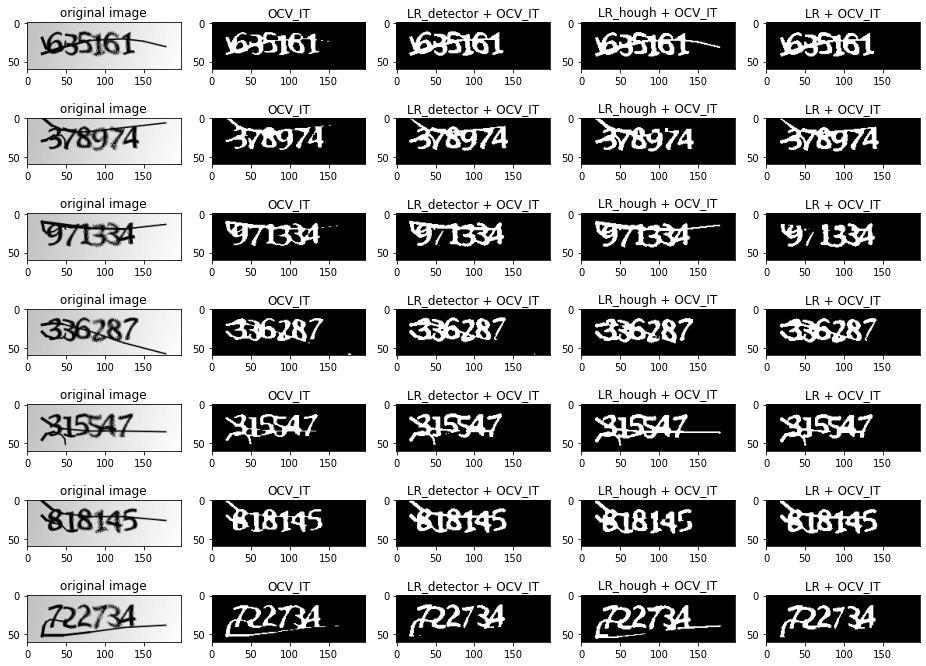

In [15]:
images_list = [images, images_ocv, images_wol_detect, images_wol_hough, images_wol]
type_list = ['original image', 'OCV_IT', 'LR_detector + OCV_IT', 'LR_hough + OCV_IT', 'LR + OCV_IT']
ImageTransform.show_images(7, images_list, type_list)

[Text(0.5, 1.0, 'Results')]

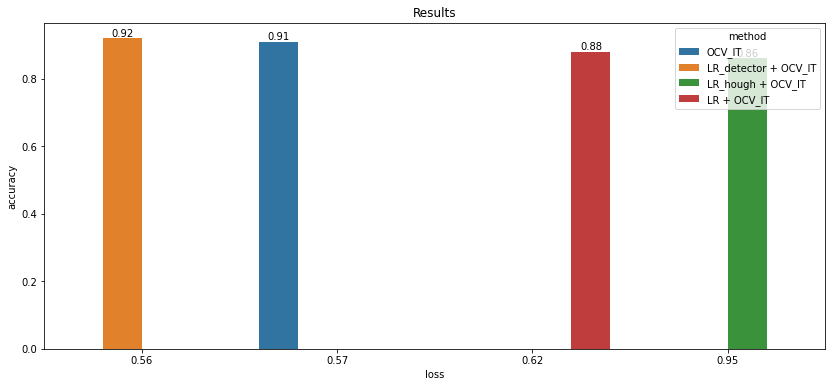

In [16]:
res_nn_df = round(res_nn_df, 2)

fig, ax = plt.subplots(figsize=(14, 6))
b = sns.barplot(x=res_nn_df['loss'], y=res_nn_df['accuracy'], hue=res_nn_df['method'], ax=ax)

for i in ax.containers:
    ax.bar_label(i,)

b.set(title='Results')

In [17]:
res_tes_df = pd.DataFrame(columns=['method', 'correctness'])

## Method 2: OCR

In [18]:
correct_rec = 0
for i in tqdm(range(1, 101)):
    image_path = 'imgs/'+str(i) + '.jpg'
    image = cv2.imread(image_path)
    correct_rec = tes_correct(correct_rec, image, labels_str[i-1])

res2 = correct_rec/len(labels_str)
tes = {'method': 'OCR', 'correctness':res2}
res_tes_df = res_tes_df.append(tes, ignore_index=True)
print('correctness:', res2)


correctness: 0.19


## Method 4: LR + OCR

### LineSegmentDetector

In [19]:
images_wol_detect2 = []
correct_rec = 0
for i in tqdm(range(1, 101)):
    image_path = 'imgs/'+str(i) + '.jpg'
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_wol_obj = LineRemoval(image)
    image_wol_obj.detect_remove()
    image_wol_obj.blur_threshold(gk1 = 3, gk2 = 3, tr=100, cv_tresh=cv2.THRESH_BINARY)
    
    images_wol_detect2.append(image_wol_obj.image)
    correct_rec = tes_correct(correct_rec, image_wol_obj.image, labels_str[i-1])
    
res31 = correct_rec/len(labels_str)
print('correctness:', res31)
tes = {'method': 'LR_detector + OCR', 'correctness': res31}
res_tes_df = res_tes_df.append(tes, ignore_index=True)


correctness: 0.27


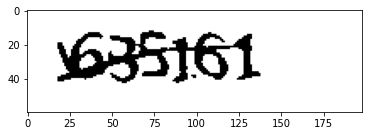

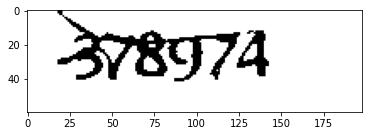

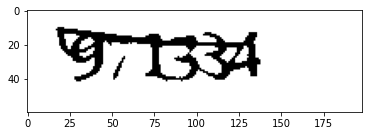

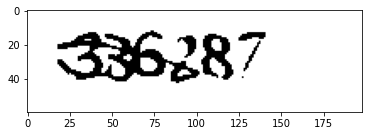

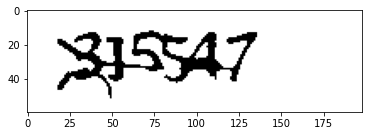

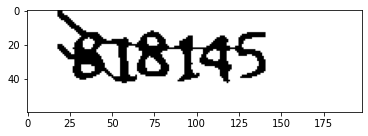

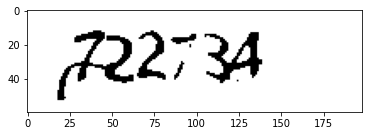

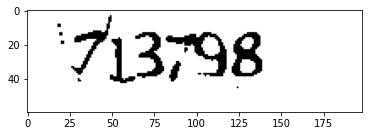

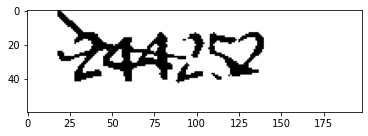

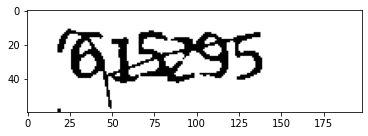

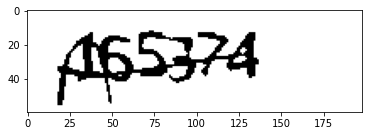

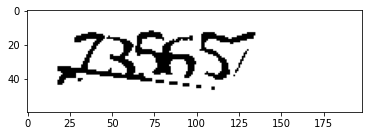

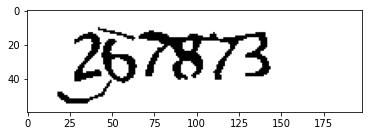

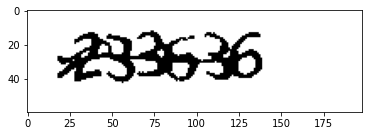

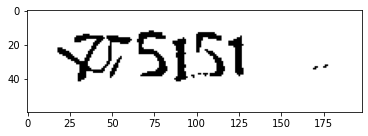

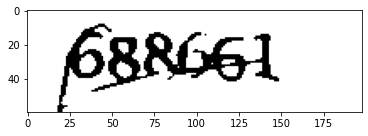

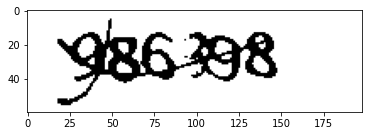

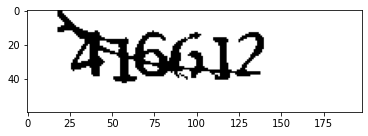

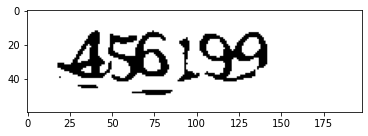

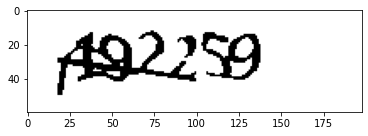

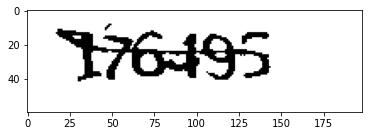

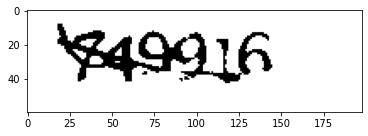

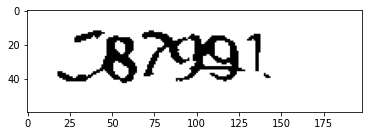

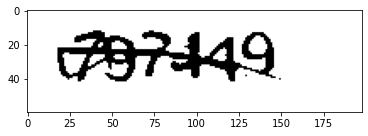

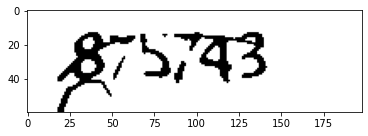

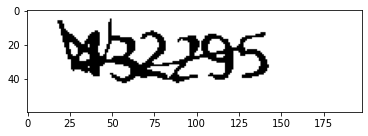

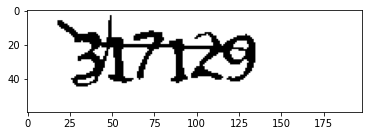

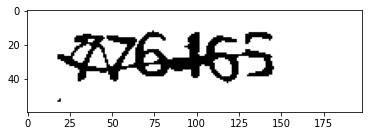

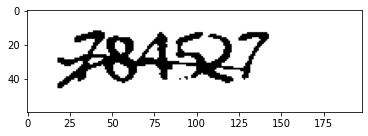

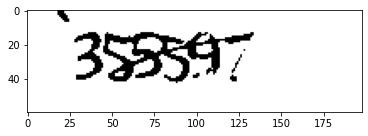

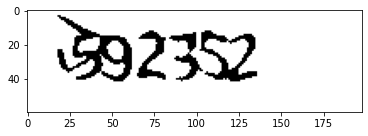

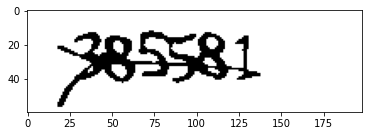

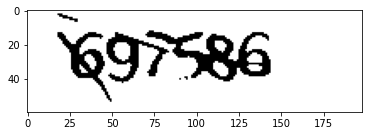

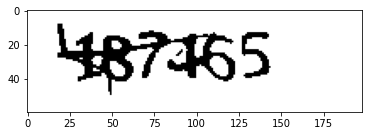

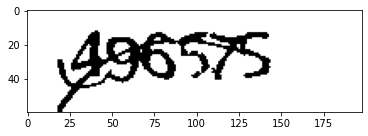

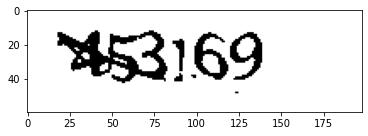

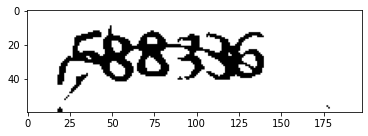

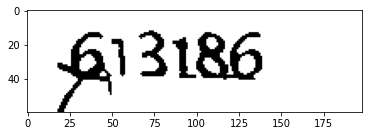

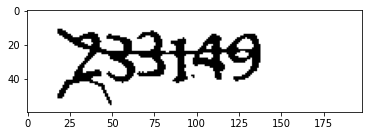

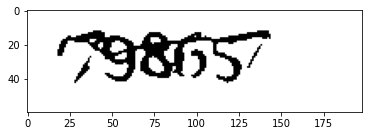

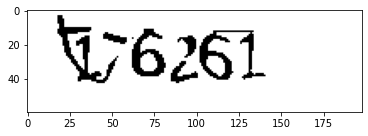

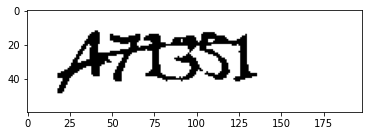

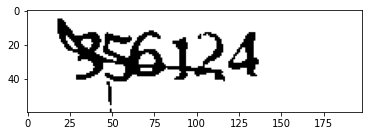

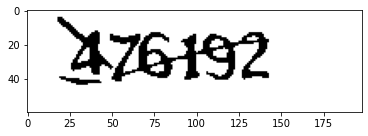

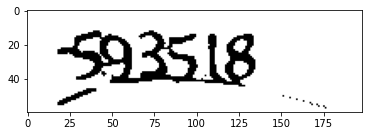

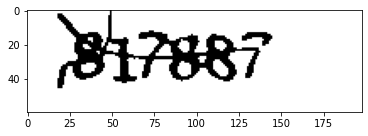

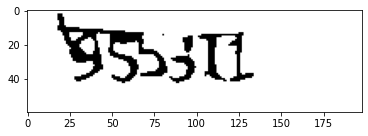

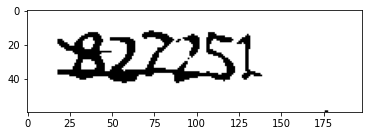

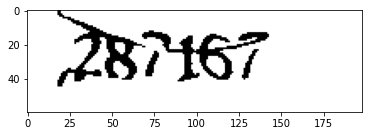

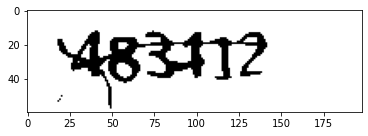

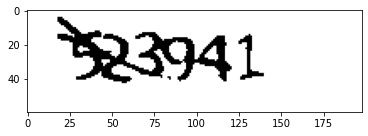

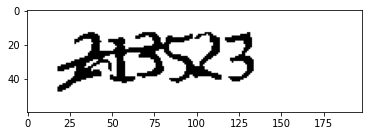

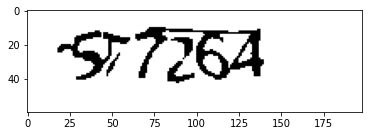

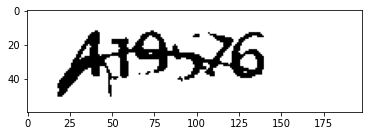

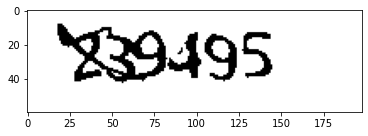

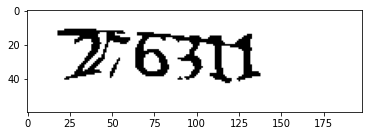

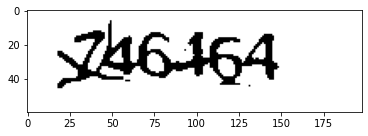

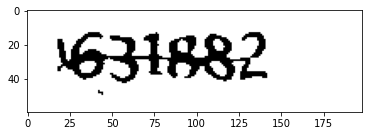

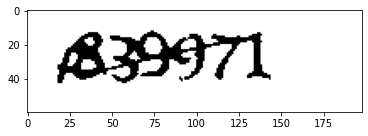

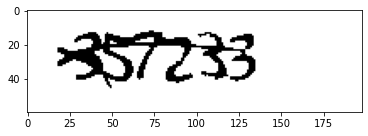

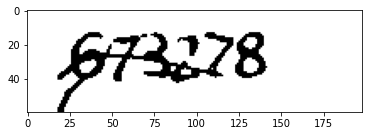

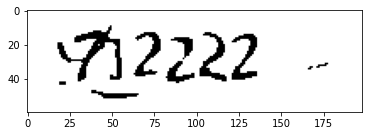

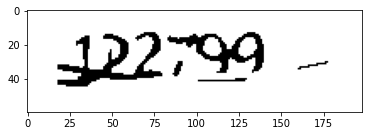

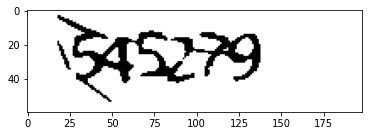

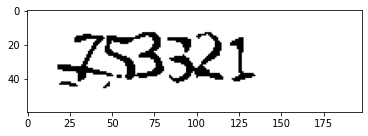

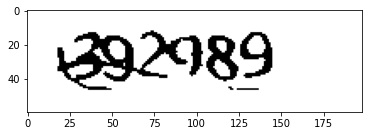

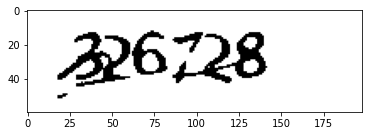

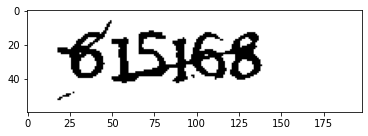

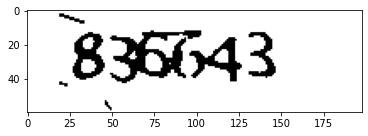

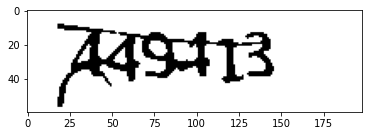

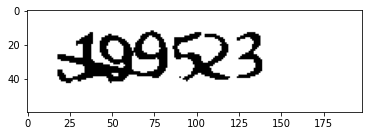

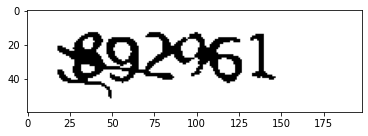

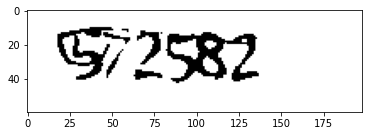

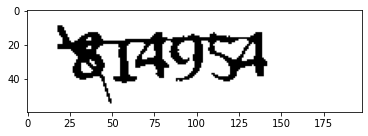

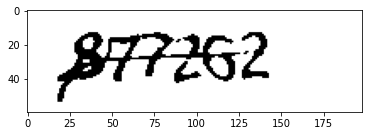

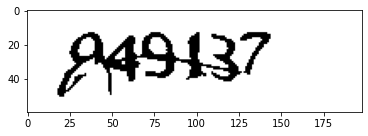

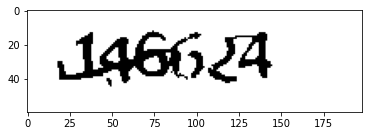

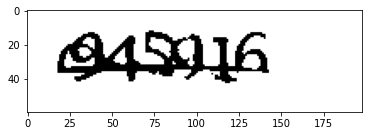

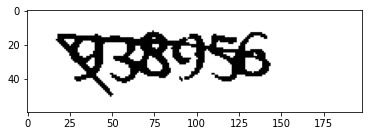

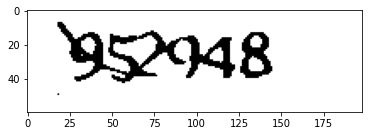

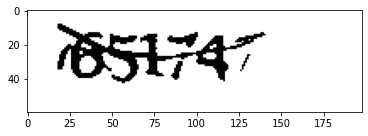

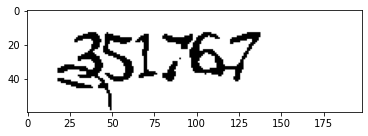

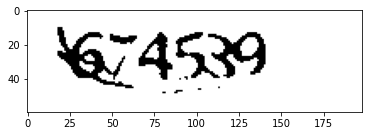

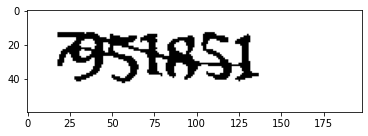

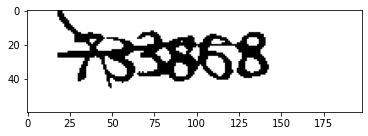

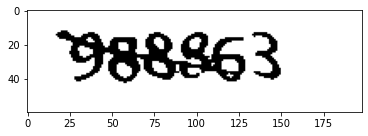

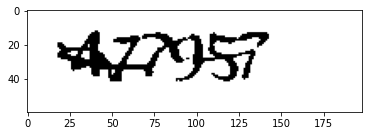

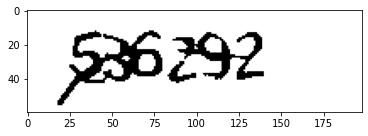

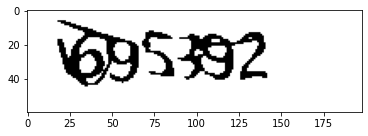

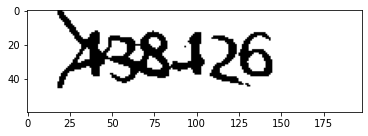

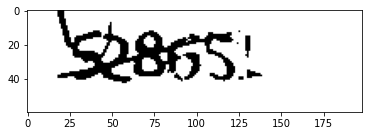

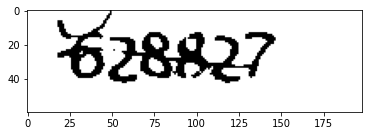

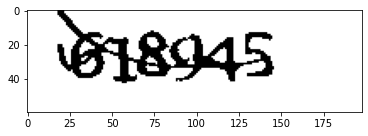

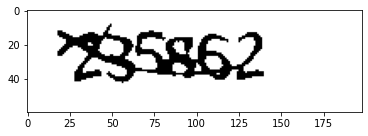

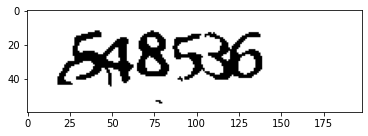

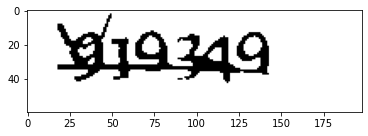

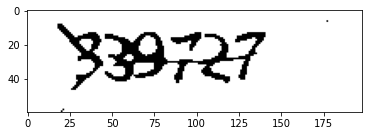

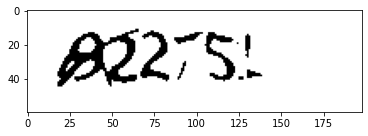

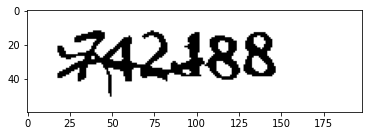

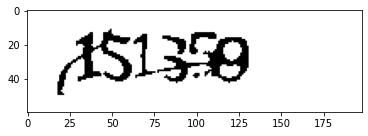

In [20]:
for elem in images_wol_detect2:
    ImageTransform.show(elem, gray=True)

### HoughLinesP

In [21]:
correct_rec = 0

for i in tqdm(range(1, 101)):
    image_path = 'imgs/'+str(i) + '.jpg'
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_wol_obj = LineRemoval(image)
    image_wol_obj.blur_threshold(gk1 = 3, gk2= 3, tr=100)
    image_wol_obj.hough_remove()
    image_wol_obj.transform_image()
    
    correct_rec = tes_correct(correct_rec, image_wol_obj.image, labels_str[i-1])
    
res32 = correct_rec/len(labels_str)
print('correctness:', res32)
tes = {'method': 'LR_hough + OCR', 'correctness': res32}
res_tes_df = res_tes_df.append(tes, ignore_index=True)


correctness: 0.09


### LineSegmentDetector + HoughLinesP

In [22]:
correct_rec = 0
for i in tqdm(range(1, 101)):
    image_path = 'imgs/'+str(i) + '.jpg'
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_wol_obj = LineRemoval(image)
    image_wol_obj.detect_remove()
    image_wol_obj.blur_threshold(gk1 = 3, gk2 = 3, tr=100)
    image_wol_obj.hough_remove()
    image_wol_obj.transform_image()
    
    correct_rec = tes_correct(correct_rec, image_wol_obj.image, labels_str[i-1])
    
res33 = correct_rec/len(labels_str)
print('correctness:', res33)
tes = {'method': 'LR + OCR', 'correctness': res33}
res_tes_df = res_tes_df.append(tes, ignore_index=True)


correctness: 0.14


## Results OCR

[Text(0.5, 1.0, 'Results')]

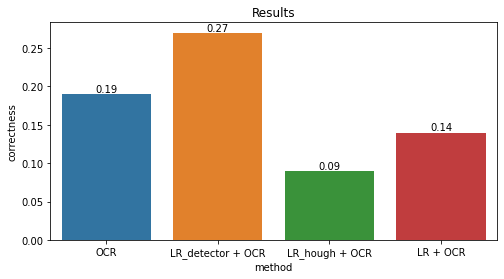

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))
res_tes_df = round(res_tes_df, 2)
b = sns.barplot(x=res_tes_df['method'], y=res_tes_df['correctness'],ax=ax)

for i in ax.containers:
    ax.bar_label(i,)

b.set(title='Results')

# api/captcha/solve

In [28]:
app1 = Flask(__name__)

@app1.route('/api/captcha/solve', methods=['POST'])
def predict():
    start = time.time()
    res = ''
    data = request.get_json()
    img_b64 = data['img']
    im_bytes = base64.b64decode(img_b64)
    im_arr = np.frombuffer(im_bytes, dtype=np.uint8)
    image = cv2.imdecode(im_arr, flags=cv2.IMREAD_GRAYSCALE)
    
    image_wol_obj = LineRemoval(image)
    image_wol_obj.detect_remove()
    image_wol_obj.blur_threshold(gk1 = 3, gk2 = 3)
    
    image_wol_obj.get_digits(digits_number = 6, start_x_coord = 25, start_y_coord = 15, digit_w = 20, digit_h = 38)
    
    for i in range(len(image_wol_obj.digits)):
        digit_img = image_wol_obj.get_digit_img(digit = image_wol_obj.digits[i], digit_w=25, digit_img_w = 50, digit_img_h_start = 10)
        x = DataTransform.transform_x_data(digit_img)
        
        pred = model_obj31.model.predict(np.expand_dims(x, axis=0), verbose=0)
        predicted = np.argmax(pred, axis=1)
        res += str(predicted[0])
    res += ' time (sec):' + str(time.time() -start)
    return res

app1.run(port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [04/Jul/2023 05:05:52] "POST /api/captcha/solve HTTP/1.1" 200 -
127.0.0.1 - - [04/Jul/2023 05:06:02] "POST /api/captcha/solve HTTP/1.1" 200 -
127.0.0.1 - - [04/Jul/2023 05:06:09] "POST /api/captcha/solve HTTP/1.1" 200 -
